In [1]:
# 如果 python 版本 >3.12 ，请将下行注释掉，否则 matplotlib 不会显示图像
# %matplotlib inline
%time from hikyuu.interactive import *
iodog.open()

Initialize hikyuu_2.6.8_202509170155_RELEASE_macosx_arm64 ...
2025-09-17 14:33:29.703 [HKU-I] - current python version: 3.12.7 (main.cpp:72)


2025-09-17 14:33:31,177 [INFO] runing in interactive session [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:110) [hikyuu::hku_info]
2025-09-17 14:33:31,178 [INFO] running in jupyter [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:117) [hikyuu::hku_info]


2025-09-17 14:33:31.181 [HKU-I] - Plugin path: /Users/fasiondog/workspace/hikyuu/hikyuu/plugin (StockManager.cpp:113)
2025-09-17 14:33:31.561 [HKU-I] - Using SQLITE3 BaseInfoDriver (BaseInfoDriver.cpp:57)
2025-09-17 14:33:31.564 [HKU-I] - 加载市场信息…… (StockManager.cpp:602)
2025-09-17 14:33:31.564 [HKU-I] - 加载证券类型信息…… (StockManager.cpp:620)
2025-09-17 14:33:31.565 [HKU-I] - 加载证券信息…… (StockManager.cpp:500)
2025-09-17 14:33:31.627 [HKU-I] - 加载权息数据…… (StockManager.cpp:638)
2025-09-17 14:33:31.787 [HKU-I] - 加载板块信息…… (StockManager.cpp:182)
2025-09-17 14:33:31.970 [HKU-I] - 加载K线数据…… (StockManager.cpp:186)
2025-09-17 14:33:31.970 [HKU-I] - 预加载 day K线数据至缓存 (最大数量: 100000)! (StockManager.cpp:231)
2025-09-17 14:33:31.970 [HKU-I] - 0.41 秒数据加载完毕. (StockManager.cpp:193)
2025-09-17 14:33:31.971 [HKU-I] - 启动行情接收. (SpotAgent.cpp:39)
CPU times: user 2.91 s, sys: 720 ms, total: 3.63 s
Wall time: 2.37 s


# 一、策略分析

## 原始描述

买入条件：周线MACD零轴下方底部金叉买入30%

卖出条件：日线级别 跌破 20日线 卖出50%持仓


## 策略分析

市场环境：无

系统有效性：无

信号指示器：
- 买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入（快线：DIF，慢线DEA）
- 卖出信号：日线级别 跌破 20日均线

止损/止盈：无

资金管理：
- 买入：30% （不明确，暂且当做当前现金的30%）
- 卖出：已持仓股票数的50%

盈利目标：

移滑价差：


# 二、实现系统部件

## 定义信号指示器

In [2]:
def getNextWeekDate(week):
    """获取指定日期的下一周周一日期"""
    from datetime import timedelta
    py_week = week.datetime()
    next_week_start = py_week + timedelta(days = 7 - py_week.weekday())
    return Datetime(next_week_start)

In [3]:
def DEMO_SG(self, k):
    """
    买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入
    卖出信号：日线级别 跌破 20日均线
    
    参数：
    week_macd_n1：周线dif窗口
    week_macd_n2: 周线dea窗口
    week_macd_n3: 周线macd平滑窗口
    day_n: 日均线窗口
    """
    if (len(k) == 0):
        return
    
    stk = k.get_stock()
    
    #-----------------------------
    #计算日线级别的卖出信号        
    #-----------------------------
    day_c = CLOSE(k)
    day_ma = MA(day_c, self.get_param("day_n"))
    day_x = day_c < day_ma  #收盘价小于均线
    for i in range(day_x.discard, len(day_x)):
        if day_x[i] >= 1.0:
            self._add_sell_signal(k[i].datetime)

    #-----------------------------
    #计算周线级别的买入信号        
    #-----------------------------
    week_q = Query(k[0].datetime, k[-1].datetime.next_day(), ktype=Query.WEEK)
    week_k = k.get_stock().get_kdata(week_q)
    
    n1 = self.get_param("week_macd_n1")
    n2 = self.get_param("week_macd_n2")
    n3 = self.get_param("week_macd_n3")
    m = MACD(CLOSE(week_k), n1, n2, n3)
    fast = m.get_result(1)
    slow = m.get_result(2)
    
    discard = m.discard if m.discard > 1 else 1
    for i in range(discard, len(m)):
        if (fast[i-1] < slow[i-1] and fast[i] > slow[i]):
            #当周计算的结果，只能作为下周一的信号
            self._add_buy_signal(week_k[i].datetime.next_week())
         

## 定义资金管理策略

In [4]:
class DEMO_MM(MoneyManagerBase):
    """
    买入：30% （不明确，暂且当做当前现金的30%）
    卖出：已持仓股票数的50%
    """
    def __init__(self):
        super(DEMO_MM, self).__init__("MACD_MM")
        
    def _reset(self):
        pass
    
    def _clone(self):
        return DEMO_MM()
        
    def _get_buy_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        cash = tm.current_cash
        
        #可以不用考虑最小交易单位的问题，已经自动处理
        # return int(cash*0.3/price) #返回类型必须是int
        return cash / price
    
    def _get_sell_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        position = tm.get_position(datetime, stk)
        total_num = position.number
        num = int(total_num * 0.5)
        return num if num >= 100 else 0

# 三、构建并运行系统

## 设定系统参数


In [5]:
#账户参数
init_cash = 100000 #账户初始资金
init_date = Datetime('1990-1-1') #账户建立日期

#信号指示器参数
week_n1 = 12
week_n2 = 26
week_n3 = 9
day_n = 20

#选定标的，及测试区间
stk = sm['sz000001']
start_date = Datetime('2017-01-01')  #如果是同一级别K线，可以使用索引号，使用了不同级别的K线数据，建议还是使用日期作为参数
end_date = Datetime()

## 构建系统实例

In [6]:
#创建账户
my_tm = crtTM(date=init_date, init_cash = init_cash, cost_func=TC_FixedA())

#创建系统实例
my_sys = SYS_Simple()

#绑定账户
my_sys.tm = my_tm

#绑定信号指示器
# !注意
# 受限与 pybind11 的限制，这里不能直接使用 my_sys.sg = crtSG(  或 my_sys.mm = DEMO_MM() , 需要先生成 Python 对象的实例再赋值
my_sg = crtSG(DEMO_SG, 
              {'week_macd_n1': week_n1, 'week_macd_n2': week_n2, 'week_macd_n3': week_n3, 'day_n': day_n}, 
                'DEMO_SG') 
my_sys.sg = my_sg
my_sys.sg.set_param('alternate', False)

#绑定资金管理策略
my_mm = DEMO_MM()
my_sys.mm = my_mm

## 运行系统

In [7]:
iodog.close()
q = Query(start_date, end_date, ktype=Query.DAY)
my_sys.run(stk, q)

#将交易记录及持仓情况，保存在临时目录，可用Excel查看
#临时目录一般设置在数据所在目录下的 tmp 子目录
#如果打开了excel记录，再次运行系统前，记得先关闭excel文件，否则新的结果没法保存
my_tm.tocsv(sm.tmpdir())

# 四、查看资金曲线及绩效统计

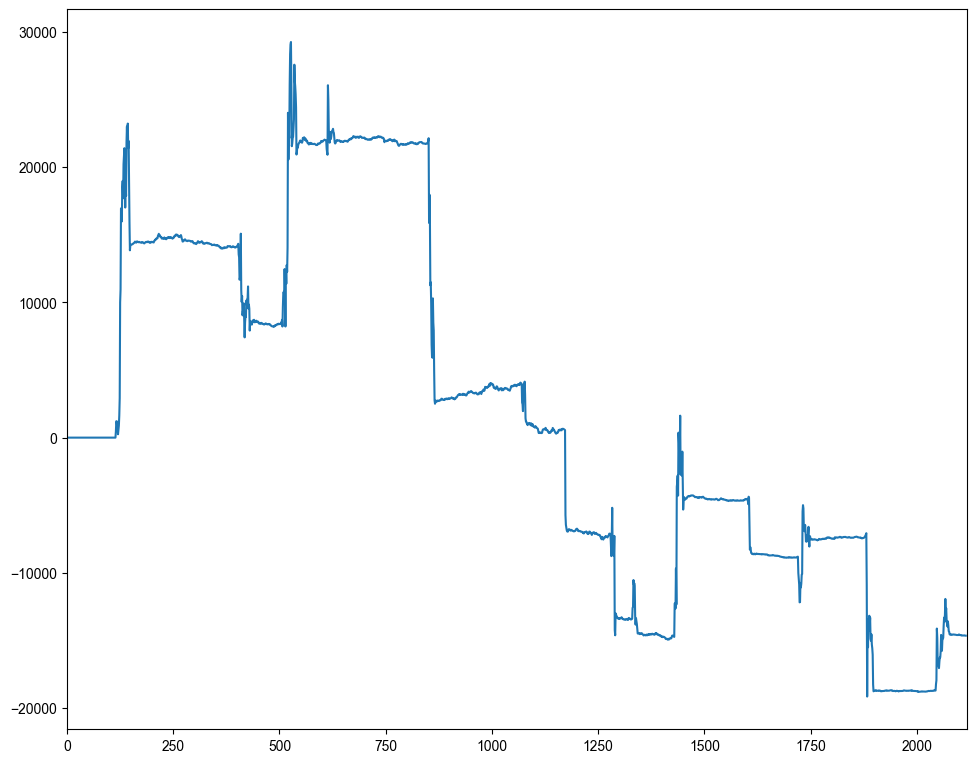

In [8]:
#绘制资金收益曲线（净收益）
x = my_tm.get_profit_curve(stk.get_datetime_list(q), Query.DAY)
#x = my_tm.getFundsCurve(stk.getDatetimeList(q), KQuery.DAY) #总资产曲线
x = PRICELIST(x)
x.plot()

In [14]:
#回测统计
per = my_tm.get_performance()
per.statistics(my_tm, Datetime.now())
print(per.report())

帐户初始金额: 100000.00
累计投入本金: 100000.00
累计投入资产: 0.00
累计借入现金: 0.00
累计借入资产: 0.00
累计红利: 6152.92
现金余额: 84106.14
未平仓头寸净值: 1257.12
当前总资产: 85363.26
已平仓交易总成本: 0.00
已平仓净利润总额: 0.00
单笔交易最大占用现金比例%: 99.89
交易平均占用现金比例%: 99.29
已平仓帐户收益率%: 0.00
帐户年复合收益率%: -1.90
帐户平均年收益率%: -1.78
赢利交易赢利总额: 0.00
亏损交易亏损总额: 0.00
已平仓交易总数: 0.00
赢利交易数: 0.00
亏损交易数: 0.00
赢利交易比例%: 0.00
赢利期望值: 0.00
赢利交易平均赢利: 0.00
亏损交易平均亏损: 0.00
平均赢利/平均亏损比例: 0.00
净赢利/亏损比例: 0.00
最大单笔赢利: 0.00
最大单笔盈利百分比%: 0.00
最大单笔亏损: 0.00
最大单笔亏损百分比%: 0.00
赢利交易平均持仓时间: 0.00
赢利交易最大持仓时间: 0.00
亏损交易平均持仓时间: 0.00
亏损交易最大持仓时间: 0.00
空仓总时间: 3005.00
空仓时间/总时间%: 100.00
平均空仓时间: 3005.00
最长空仓时间: 3004.00
最大连续赢利笔数: 0.00
最大连续亏损笔数: 0.00
最大连续赢利金额: 0.00
最大连续亏损金额: 0.00
R乘数期望值: 0.00
交易机会频率/年: 0.00
年度期望R乘数: 0.00
赢利交易平均R乘数: 0.00
亏损交易平均R乘数: 0.00
最大单笔赢利R乘数: 0.00
最大单笔亏损R乘数: 0.00
最大连续赢利R乘数: 0.00
最大连续亏损R乘数: 0.00
最大回撤百分比: 0.00
夏普比率: 0.00
单笔交易盈亏百分比均值: 0.00
单笔交易盈亏百分比标准差: nan



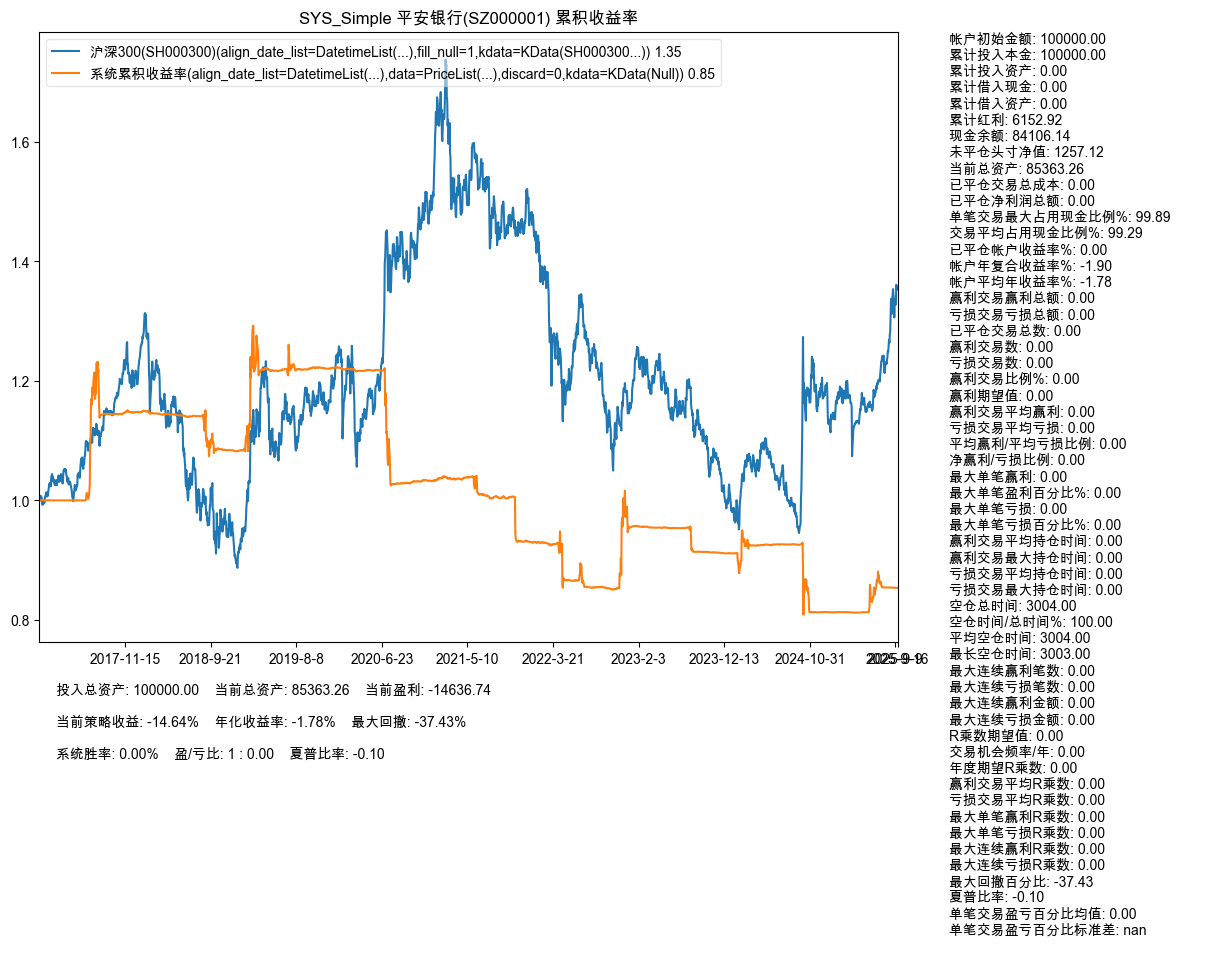

In [15]:
my_sys.performance()

# 五、或许想看下图形

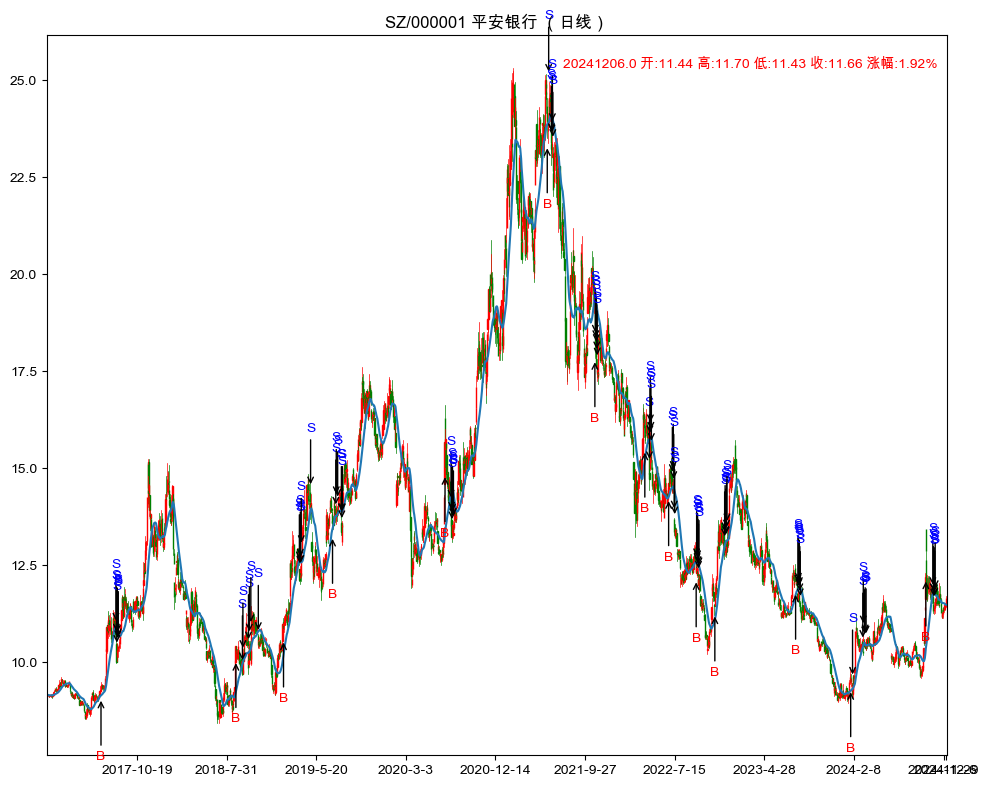

In [11]:
my_sys.plot()
MA(CLOSE(my_sys.to), 20).plot(new=False)

# 六、或许想看看所有股票的情况

In [12]:
import pandas as pd
def calTotal(blk, q):
    per = Performance()
    s_name = []
    s_code = []
    x = []
    for stk in blk:
        my_sys.run(stk, q)
        per.statistics(my_tm, Datetime.now())
        s_name.append(stk.name)
        s_code.append(stk.market_code)
        x.append(per["当前总资产"])
    return pd.DataFrame({'代码': s_code, '股票': s_name, '当前总资产': x})

%time data = calTotal(blocka, q)

CPU times: user 16.1 s, sys: 1.58 s, total: 17.7 s
Wall time: 16.7 s


In [13]:
#保存到CSV文件
#data.to_csv(sm.tmpdir() + '/统计.csv')
data[:10]

,代码,股票,当前总资产
0,SH601003,柳钢股份,66414.81
1,SH603180,金牌家居,65716.52
2,SZ000548,湖南投资,63616.49
3,SH600159,大龙地产,40364.84
4,SZ002099,海翔药业,53875.08
5,SH600732,爱旭股份,198582.34
6,SH603127,昭衍新药,131866.78
7,SZ002953,日丰股份,69972.42
8,SH603758,秦安股份,72336.15
9,SZ002962,五方光电,54827.43
